
# QGAN: (Q-Net) + GAN (G-Net and D-Net)

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [3]:
import gym
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    print('state, action, reward, done, info')
    print(state, action, reward, done, info)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

state, action, reward, done, info
[-0.02596259 -0.16876479  0.00053544  0.33500196] 0 1.0 False {}
state, action, reward, done, info
[-0.02933788  0.02634954  0.00723548  0.04248794] 1 1.0 False {}
state, action, reward, done, info
[-0.02881089  0.22136699  0.00808524 -0.24790337] 1 1.0 False {}
state, action, reward, done, info
[-0.02438355  0.02613051  0.00312717  0.04731881] 0 1.0 False {}
state, action, reward, done, info
[-0.02386094  0.22120748  0.00407355 -0.24437582] 1 1.0 False {}
state, action, reward, done, info
[-0.01943679  0.41627101 -0.00081397 -0.53577107] 1 1.0 False {}
state, action, reward, done, info
[-0.01111137  0.6114044  -0.01152939 -0.82871036] 1 1.0 False {}
state, action, reward, done, info
[ 1.11671364e-03  8.06682058e-01 -2.81035957e-02 -1.12499695e+00] 1 1.0 False {}
state, action, reward, done, info
[ 0.01725035  1.00216085 -0.05060353 -1.42636073] 1 1.0 False {}
state, action, reward, done, info
[ 0.03729357  1.19787026 -0.07913075 -1.73442014] 1 1.0 Fal

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
1 0
2
1.0 1.0
1.197870256697169 -1.7344201387609663


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [6]:
# Data of the model
def model_input(state_size):
    # Current states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    
    # Next states given
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Current actions given
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # TargetQs/values
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    
    # returning the given data to the model
    return states, next_states, actions, targetQs

In [38]:
# Q: Qfunction/Encoder/Classifier
def qfunction(states, action_size, hidden_size, reuse=False, alpha=0.1, training=True):
    with tf.variable_scope('qfunction', reuse=reuse):        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(inputs=h1, training=training)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        #bn2 = tf.layers.batch_normalization(inputs=h2, training=training)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [26]:
# G: Generator/Decoder: actions can be given actions, generated actions
def generator(actions, state_size, hidden_size, reuse=False, alpha=0.1):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        #predictions = tf.sigmoid(logits)

        # return next_states_logits
        return logits

In [27]:
# D: Descriminator/Reward function
def discriminator(states, hidden_size, reuse=False, alpha=0.1):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)   
        #predictions = tf.sigmoid(logits)

        # return reward logits
        return logits

In [28]:
def model_loss(states, action_size, hidden_size, actions, targetQs, state_size, next_states, alpha=0.1):
    # DQN: Q-learning - Bellman equations: loss (targetQ - Q)^2
    actions_logits = qfunction(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_real = tf.one_hot(actions, action_size)
    Qs = tf.reduce_sum(tf.multiply(actions_logits, actions_real), axis=1)
    q_loss = tf.reduce_mean(tf.square(targetQs - Qs))

    # GAN: Generate next states
    actions_fake = tf.nn.softmax(actions_logits)
    next_states_logits = generator(actions=actions_fake, state_size=state_size, hidden_size=hidden_size)
    
    # GAN: Discriminate between fake and real
    next_states_fake = tf.sigmoid(x=next_states_logits)
    d_logits_fake = discriminator(states=next_states_fake, hidden_size=hidden_size, reuse=False)
    next_states_real = tf.sigmoid(x=next_states) 
    d_logits_real = discriminator(states=next_states_real, hidden_size=hidden_size, reuse=True)

    # GAN: Adverserial training - G-learning
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    # GAN: Adverserial training - D-learning
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake
    
    # Rewards fake/real
    rewards_fake = tf.sigmoid(d_logits_fake)
    rewards_real = tf.sigmoid(d_logits_real)

    return actions_logits, q_loss, g_loss, d_loss, rewards_fake, rewards_real

In [29]:
def model_opt(q_loss, g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param q_loss: Qfunction/Value loss Tensor for next action prediction
    :param g_loss: Generator/Decoder loss Tensor for next state prediction
    :param d_loss: Discriminator/Reward loss Tensor for current reward function
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    q_vars = [var for var in t_vars if var.name.startswith('qfunction')] # Q: action At/at
    g_vars = [var for var in t_vars if var.name.startswith('generator')] # G: next state St/st
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')] # D: reward Rt/rt

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=q_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return q_opt, g_opt, d_opt

In [34]:
class QGAN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.next_states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.q_loss, self.g_loss, self.d_loss, self.rewards_fake, self.rewards_real = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, next_states=self.next_states, actions=self.actions, targetQs=self.targetQs) # model input data

        # Update the model: backward pass and backprop
        self.q_opt, self.g_opt, self.d_opt = model_opt(q_loss=self.q_loss, g_loss=self.g_loss, d_loss=self.d_loss, 
                                                       learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [35]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [36]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000            # memory capacity
batch_size = 10                 # experience mini-batch size
learning_rate = 0.001           # learning rate for adam

In [37]:
tf.reset_default_graph()

model = QGAN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [27]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [28]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list, rewards_fake_list, rewards_real_list = [], [], []
d_loss_list, g_loss_list, q_loss_list = [], [], [] 

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Restore/load the trained model 
    saver.restore(sess, 'checkpoints/Q-GAN-cartpole.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward, rewards_fake_mean, rewards_real_mean = 0, 0, 0
        d_loss, g_loss, q_loss = 0, 0, 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Average reward fake: {}'.format(rewards_fake_mean),
                      'Average reward real: {}'.format(rewards_real_mean),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                rewards_fake_list.append((ep, rewards_fake_mean))
                d_loss_list.append((ep, d_loss))
                g_loss_list.append((ep, g_loss))
                q_loss_list.append((ep, q_loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train the model
            feed_dict = {model.states: states, model.next_states: next_states, model.actions: actions}
            rewards_fake, rewards_real = sess.run([model.rewards_fake, model.rewards_real], feed_dict)
            feed_dict={model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)

            # Mean/average fake and real rewards or rewarded generated/given actions
            rewards_fake_mean = np.mean(rewards_fake.reshape(-1))
            rewards_real_mean = np.mean(rewards_real.reshape(-1))
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_actions_logits[episode_ends] = (0, 0)

            # Bellman equation: Qt = Rt + max(Qt+1)
            targetQs = rewards_fake.reshape(-1) + (gamma * np.max(next_actions_logits, axis=1))

            # Updating the model
            feed_dict = {model.states: states, model.next_states: next_states, model.actions: actions, 
                         model.targetQs: targetQs}
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            
    # Save the trained model 
    saver.save(sess, 'checkpoints/Q-GAN-cartpole.ckpt')

INFO:tensorflow:Restoring parameters from checkpoints/Q-GAN-cartpole.ckpt
-------------------------------------------------------------------------------
Episode: 0 Total reward: 24.0 Average reward fake: 0.4204567074775696 Average reward real: 0.5814465284347534 Training q_loss: 18282.8672 Training g_loss: 0.8711 Training d_loss: 1.1577 Explore P: 0.9976
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 19.0 Average reward fake: 0.39258790016174316 Average reward real: 0.5221540927886963 Training q_loss: 24111.0137 Training g_loss: 1.0674 Training d_loss: 1.3367 Explore P: 0.9958
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 23.0 Average reward fake: 0.5419694781303406 Average reward real: 0.4497351050376892 Trainin

-------------------------------------------------------------------------------
Episode: 23 Total reward: 20.0 Average reward fake: 0.4569394588470459 Average reward real: 0.5838934183120728 Training q_loss: 34053.3867 Training g_loss: 0.7832 Training d_loss: 1.1724 Explore P: 0.9437
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 24 Total reward: 14.0 Average reward fake: 0.4404301643371582 Average reward real: 0.520039439201355 Training q_loss: 27993.0469 Training g_loss: 0.8200 Training d_loss: 1.2819 Explore P: 0.9423
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 25 Total reward: 31.0 Average reward fake: 0.4998164176940918 Average reward real: 0.43928661942481995 Training q_loss: 51775.3008 Training g_loss: 0.6938 Training d_loss: 1.5422 Exp

-------------------------------------------------------------------------------
Episode: 46 Total reward: 29.0 Average reward fake: 0.5401924848556519 Average reward real: 0.5859674215316772 Training q_loss: 39676.7891 Training g_loss: 0.6223 Training d_loss: 1.3314 Explore P: 0.8808
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 47 Total reward: 28.0 Average reward fake: 0.5034719109535217 Average reward real: 0.5177061557769775 Training q_loss: 20564.2930 Training g_loss: 0.6949 Training d_loss: 1.3787 Explore P: 0.8784
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 48 Total reward: 16.0 Average reward fake: 0.4676286280155182 Average reward real: 0.5824726819992065 Training q_loss: 8675.8057 Training g_loss: 0.7660 Training d_loss: 1.1838 Expl

-------------------------------------------------------------------------------
Episode: 69 Total reward: 60.0 Average reward fake: 0.5681736469268799 Average reward real: 0.5030367374420166 Training q_loss: 147678.1250 Training g_loss: 0.5653 Training d_loss: 1.5292 Explore P: 0.8045
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 70 Total reward: 71.0 Average reward fake: 0.47566723823547363 Average reward real: 0.5316663980484009 Training q_loss: 741684.8750 Training g_loss: 0.7435 Training d_loss: 1.2835 Explore P: 0.7989
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 71 Total reward: 67.0 Average reward fake: 0.5128970742225647 Average reward real: 0.47890692949295044 Training q_loss: 122630.3516 Training g_loss: 0.6701 Training d_loss: 1.466

-------------------------------------------------------------------------------
Episode: 92 Total reward: 21.0 Average reward fake: 0.47465935349464417 Average reward real: 0.48809295892715454 Training q_loss: 133397.5312 Training g_loss: 0.7454 Training d_loss: 1.3687 Explore P: 0.7207
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 93 Total reward: 135.0 Average reward fake: 0.4281584620475769 Average reward real: 0.494112104177475 Training q_loss: 223921.9531 Training g_loss: 0.8527 Training d_loss: 1.3035 Explore P: 0.7111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 94 Total reward: 28.0 Average reward fake: 0.4721308648586273 Average reward real: 0.5127559900283813 Training q_loss: 140662.5938 Training g_loss: 0.7506 Training d_loss: 1.330

-------------------------------------------------------------------------------
Episode: 115 Total reward: 199.0 Average reward fake: 0.305251806974411 Average reward real: 0.7040877342224121 Training q_loss: 241332.7969 Training g_loss: 2.3882 Training d_loss: 0.8888 Explore P: 0.6147
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 116 Total reward: 33.0 Average reward fake: 0.17021022737026215 Average reward real: 0.5100800395011902 Training q_loss: 231365.0938 Training g_loss: 3.0950 Training d_loss: 0.9308 Explore P: 0.6127
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 117 Total reward: 199.0 Average reward fake: 0.3384176194667816 Average reward real: 0.605197012424469 Training q_loss: 169585.6250 Training g_loss: 1.1942 Training d_loss: 0.9

-------------------------------------------------------------------------------
Episode: 138 Total reward: 118.0 Average reward fake: 0.5275454521179199 Average reward real: 0.5130124092102051 Training q_loss: 77097.9531 Training g_loss: 0.6418 Training d_loss: 1.4607 Explore P: 0.5177
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 139 Total reward: 125.0 Average reward fake: 0.47259196639060974 Average reward real: 0.6042556166648865 Training q_loss: 141445.8125 Training g_loss: 0.7495 Training d_loss: 1.1700 Explore P: 0.5114
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 140 Total reward: 74.0 Average reward fake: 0.48936301469802856 Average reward real: 0.4109097421169281 Training q_loss: 189804.3906 Training g_loss: 0.7149 Training d_loss: 1

-------------------------------------------------------------------------------
Episode: 161 Total reward: 43.0 Average reward fake: 0.4705209732055664 Average reward real: 0.5278359651565552 Training q_loss: 36953.5234 Training g_loss: 0.7632 Training d_loss: 1.2991 Explore P: 0.3785
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 162 Total reward: 179.0 Average reward fake: 0.5510030388832092 Average reward real: 0.5506841540336609 Training q_loss: 113052.1016 Training g_loss: 0.5961 Training d_loss: 1.3998 Explore P: 0.3720
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 163 Total reward: 199.0 Average reward fake: 0.4535173773765564 Average reward real: 0.5252679586410522 Training q_loss: 204089.1094 Training g_loss: 0.8017 Training d_loss: 1.2

-------------------------------------------------------------------------------
Episode: 184 Total reward: 199.0 Average reward fake: 0.458404541015625 Average reward real: 0.491157591342926 Training q_loss: 114291.3906 Training g_loss: 0.7807 Training d_loss: 1.3340 Explore P: 0.2445
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 185 Total reward: 199.0 Average reward fake: 0.4670894145965576 Average reward real: 0.4731351435184479 Training q_loss: 54540.2891 Training g_loss: 0.7662 Training d_loss: 1.3802 Explore P: 0.2399
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 186 Total reward: 199.0 Average reward fake: 0.4838961660861969 Average reward real: 0.5372415781021118 Training q_loss: 105898.7266 Training g_loss: 0.7288 Training d_loss: 1.29

-------------------------------------------------------------------------------
Episode: 207 Total reward: 199.0 Average reward fake: 0.43312138319015503 Average reward real: 0.4845059812068939 Training q_loss: 25800.1133 Training g_loss: 0.8405 Training d_loss: 1.3867 Explore P: 0.1586
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 208 Total reward: 199.0 Average reward fake: 0.5282655954360962 Average reward real: 0.36838704347610474 Training q_loss: 4601.1484 Training g_loss: 0.6382 Training d_loss: 1.7759 Explore P: 0.1556
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 209 Total reward: 199.0 Average reward fake: 0.5182547569274902 Average reward real: 0.4216708242893219 Training q_loss: 25683.2422 Training g_loss: 0.6525 Training d_loss: 1.6

-------------------------------------------------------------------------------
Episode: 230 Total reward: 199.0 Average reward fake: 0.47755932807922363 Average reward real: 0.4511236250400543 Training q_loss: 2193.8784 Training g_loss: 0.7391 Training d_loss: 1.4494 Explore P: 0.1040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 231 Total reward: 184.0 Average reward fake: 0.5275939702987671 Average reward real: 0.48729223012924194 Training q_loss: 1423.7328 Training g_loss: 0.6395 Training d_loss: 1.4737 Explore P: 0.1023
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 232 Total reward: 199.0 Average reward fake: 0.4965313971042633 Average reward real: 0.5358430743217468 Training q_loss: 10207.6797 Training g_loss: 0.7000 Training d_loss: 1.31

-------------------------------------------------------------------------------
Episode: 253 Total reward: 199.0 Average reward fake: 0.4878483712673187 Average reward real: 0.5258038640022278 Training q_loss: 149.5257 Training g_loss: 0.7178 Training d_loss: 1.3139 Explore P: 0.0704
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 254 Total reward: 199.0 Average reward fake: 0.4901901185512543 Average reward real: 0.5224734544754028 Training q_loss: 318.0114 Training g_loss: 0.7129 Training d_loss: 1.3247 Explore P: 0.0692
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 255 Total reward: 199.0 Average reward fake: 0.4497069716453552 Average reward real: 0.49342140555381775 Training q_loss: 2965.4211 Training g_loss: 0.7992 Training d_loss: 1.3185 E

-------------------------------------------------------------------------------
Episode: 276 Total reward: 175.0 Average reward fake: 0.5565627813339233 Average reward real: 0.5051973462104797 Training q_loss: 2025.0186 Training g_loss: 0.6206 Training d_loss: 1.5885 Explore P: 0.0494
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 277 Total reward: 198.0 Average reward fake: 0.36991971731185913 Average reward real: 0.5112835764884949 Training q_loss: 1860.8103 Training g_loss: 0.9945 Training d_loss: 1.1809 Explore P: 0.0486
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 278 Total reward: 191.0 Average reward fake: 0.48948588967323303 Average reward real: 0.44541844725608826 Training q_loss: 160.7367 Training g_loss: 0.7146 Training d_loss: 1.488

-------------------------------------------------------------------------------
Episode: 299 Total reward: 127.0 Average reward fake: 0.503320574760437 Average reward real: 0.5215480327606201 Training q_loss: 1721.2484 Training g_loss: 0.6867 Training d_loss: 1.3573 Explore P: 0.0365
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 300 Total reward: 162.0 Average reward fake: 0.4741266369819641 Average reward real: 0.5130944848060608 Training q_loss: 2850.3098 Training g_loss: 0.7418 Training d_loss: 1.3349 Explore P: 0.0361
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 301 Total reward: 174.0 Average reward fake: 0.4728993773460388 Average reward real: 0.5025321245193481 Training q_loss: 339.1187 Training g_loss: 0.7490 Training d_loss: 1.3321 Ex

-------------------------------------------------------------------------------
Episode: 322 Total reward: 199.0 Average reward fake: 0.4926993250846863 Average reward real: 0.5503410696983337 Training q_loss: 263.7428 Training g_loss: 0.7087 Training d_loss: 1.2943 Explore P: 0.0280
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 323 Total reward: 162.0 Average reward fake: 0.5616775155067444 Average reward real: 0.4625791609287262 Training q_loss: 845.2346 Training g_loss: 0.5771 Training d_loss: 1.5996 Explore P: 0.0277
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 324 Total reward: 199.0 Average reward fake: 0.42722249031066895 Average reward real: 0.5058879852294922 Training q_loss: 322.9718 Training g_loss: 0.8648 Training d_loss: 1.2759 Ex

-------------------------------------------------------------------------------
Episode: 345 Total reward: 152.0 Average reward fake: 0.4274420142173767 Average reward real: 0.5757232904434204 Training q_loss: 243.3073 Training g_loss: 0.8479 Training d_loss: 1.1243 Explore P: 0.0225
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 346 Total reward: 160.0 Average reward fake: 0.3763856291770935 Average reward real: 0.6316100358963013 Training q_loss: 417.7100 Training g_loss: 0.9771 Training d_loss: 0.9458 Explore P: 0.0223
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 347 Total reward: 125.0 Average reward fake: 0.7428837418556213 Average reward real: 0.34628409147262573 Training q_loss: 1868.3851 Training g_loss: 0.2995 Training d_loss: 2.8992 E

-------------------------------------------------------------------------------
Episode: 368 Total reward: 199.0 Average reward fake: 0.4552103579044342 Average reward real: 0.4741528630256653 Training q_loss: 1100.4156 Training g_loss: 0.7873 Training d_loss: 1.3642 Explore P: 0.0187
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 369 Total reward: 199.0 Average reward fake: 0.5020219087600708 Average reward real: 0.4355746805667877 Training q_loss: 503.7484 Training g_loss: 0.6956 Training d_loss: 1.6123 Explore P: 0.0185
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 370 Total reward: 176.0 Average reward fake: 0.6115509867668152 Average reward real: 0.49054521322250366 Training q_loss: 224.6368 Training g_loss: 0.4918 Training d_loss: 1.6934 E

-------------------------------------------------------------------------------
Episode: 391 Total reward: 199.0 Average reward fake: 0.475046306848526 Average reward real: 0.5391676425933838 Training q_loss: 226.8031 Training g_loss: 0.7444 Training d_loss: 1.2683 Explore P: 0.0158
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 392 Total reward: 199.0 Average reward fake: 0.42287635803222656 Average reward real: 0.5101362466812134 Training q_loss: 74.9997 Training g_loss: 0.8615 Training d_loss: 1.2364 Explore P: 0.0157
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 393 Total reward: 199.0 Average reward fake: 0.4154703617095947 Average reward real: 0.5285642743110657 Training q_loss: 650.9386 Training g_loss: 0.8916 Training d_loss: 1.2340 Expl

-------------------------------------------------------------------------------
Episode: 414 Total reward: 127.0 Average reward fake: 0.5204195976257324 Average reward real: 0.5266969203948975 Training q_loss: 110.3188 Training g_loss: 0.6555 Training d_loss: 1.4174 Explore P: 0.0139
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 415 Total reward: 199.0 Average reward fake: 0.3894517123699188 Average reward real: 0.5109034776687622 Training q_loss: 99.1503 Training g_loss: 0.9426 Training d_loss: 1.1987 Explore P: 0.0139
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 416 Total reward: 199.0 Average reward fake: 0.48206764459609985 Average reward real: 0.5518771409988403 Training q_loss: 114.4008 Training g_loss: 0.7301 Training d_loss: 1.2888 Exp

-------------------------------------------------------------------------------
Episode: 437 Total reward: 199.0 Average reward fake: 0.4697692394256592 Average reward real: 0.5087342858314514 Training q_loss: 259.5042 Training g_loss: 0.7556 Training d_loss: 1.3239 Explore P: 0.0129
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 438 Total reward: 199.0 Average reward fake: 0.5513381361961365 Average reward real: 0.47469472885131836 Training q_loss: 657.5839 Training g_loss: 0.5961 Training d_loss: 1.5550 Explore P: 0.0129
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 439 Total reward: 199.0 Average reward fake: 0.45395708084106445 Average reward real: 0.5233615040779114 Training q_loss: 487.4044 Training g_loss: 0.7891 Training d_loss: 1.2643 E

-------------------------------------------------------------------------------
Episode: 461 Total reward: 9.0 Average reward fake: 0.5046285390853882 Average reward real: 0.4501716196537018 Training q_loss: 227.4487 Training g_loss: 0.6839 Training d_loss: 1.5122 Explore P: 0.0123
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 462 Total reward: 9.0 Average reward fake: 0.5377441048622131 Average reward real: 0.486342191696167 Training q_loss: 183.8541 Training g_loss: 0.6204 Training d_loss: 1.5043 Explore P: 0.0123
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 463 Total reward: 22.0 Average reward fake: 0.5049028992652893 Average reward real: 0.4676598906517029 Training q_loss: 1755.9290 Training g_loss: 0.6834 Training d_loss: 1.4673 Explore 

-------------------------------------------------------------------------------
Episode: 484 Total reward: 105.0 Average reward fake: 0.4915735721588135 Average reward real: 0.5438879132270813 Training q_loss: 453.8197 Training g_loss: 0.7104 Training d_loss: 1.3059 Explore P: 0.0118
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 485 Total reward: 132.0 Average reward fake: 0.4850139617919922 Average reward real: 0.5420669913291931 Training q_loss: 918.8976 Training g_loss: 0.7238 Training d_loss: 1.2818 Explore P: 0.0118
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 486 Total reward: 164.0 Average reward fake: 0.44752198457717896 Average reward real: 0.5312772989273071 Training q_loss: 277.3707 Training g_loss: 0.8273 Training d_loss: 1.2523 Ex

-------------------------------------------------------------------------------
Episode: 507 Total reward: 134.0 Average reward fake: 0.5646604299545288 Average reward real: 0.5124894976615906 Training q_loss: 337.0127 Training g_loss: 0.5773 Training d_loss: 1.4996 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 508 Total reward: 102.0 Average reward fake: 0.4992976784706116 Average reward real: 0.478329598903656 Training q_loss: 725.5929 Training g_loss: 0.6946 Training d_loss: 1.4313 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 509 Total reward: 123.0 Average reward fake: 0.46600693464279175 Average reward real: 0.4946311116218567 Training q_loss: 850.5379 Training g_loss: 0.7639 Training d_loss: 1.3697 Exp

-------------------------------------------------------------------------------
Episode: 530 Total reward: 152.0 Average reward fake: 0.46679621934890747 Average reward real: 0.48753562569618225 Training q_loss: 1047.4153 Training g_loss: 0.7619 Training d_loss: 1.3505 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 531 Total reward: 148.0 Average reward fake: 0.48314183950424194 Average reward real: 0.4728679656982422 Training q_loss: 217.8085 Training g_loss: 0.7247 Training d_loss: 1.4171 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 532 Total reward: 121.0 Average reward fake: 0.48570483922958374 Average reward real: 0.5132116079330444 Training q_loss: 129.1206 Training g_loss: 0.7222 Training d_loss: 1.352

-------------------------------------------------------------------------------
Episode: 553 Total reward: 160.0 Average reward fake: 0.5394529700279236 Average reward real: 0.4974249303340912 Training q_loss: 150.0118 Training g_loss: 0.6178 Training d_loss: 1.4797 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 554 Total reward: 156.0 Average reward fake: 0.5032060146331787 Average reward real: 0.4874902665615082 Training q_loss: 455.7651 Training g_loss: 0.6867 Training d_loss: 1.4188 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 555 Total reward: 100.0 Average reward fake: 0.4881351888179779 Average reward real: 0.47972720861434937 Training q_loss: 15992.1973 Training g_loss: 0.7172 Training d_loss: 1.4047 

-------------------------------------------------------------------------------
Episode: 576 Total reward: 123.0 Average reward fake: 0.4234227240085602 Average reward real: 0.4846786558628082 Training q_loss: 256.0940 Training g_loss: 0.8603 Training d_loss: 1.2785 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 577 Total reward: 181.0 Average reward fake: 0.5159276723861694 Average reward real: 0.4982419013977051 Training q_loss: 250.7982 Training g_loss: 0.6618 Training d_loss: 1.4701 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 578 Total reward: 164.0 Average reward fake: 0.41712093353271484 Average reward real: 0.4941374659538269 Training q_loss: 45.4572 Training g_loss: 0.8767 Training d_loss: 1.2738 Exp

-------------------------------------------------------------------------------
Episode: 600 Total reward: 10.0 Average reward fake: 0.48037058115005493 Average reward real: 0.46375465393066406 Training q_loss: 2687.5356 Training g_loss: 0.7332 Training d_loss: 1.4465 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 601 Total reward: 10.0 Average reward fake: 0.48090729117393494 Average reward real: 0.5031229853630066 Training q_loss: 184.5788 Training g_loss: 0.7321 Training d_loss: 1.3684 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 602 Total reward: 24.0 Average reward fake: 0.5185003280639648 Average reward real: 0.47448182106018066 Training q_loss: 466.7555 Training g_loss: 0.6568 Training d_loss: 1.4893 E

-------------------------------------------------------------------------------
Episode: 623 Total reward: 169.0 Average reward fake: 0.5473901033401489 Average reward real: 0.4847136437892914 Training q_loss: 1621.1653 Training g_loss: 0.6039 Training d_loss: 1.5375 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 624 Total reward: 199.0 Average reward fake: 0.45347875356674194 Average reward real: 0.517043948173523 Training q_loss: 46.3392 Training g_loss: 0.7909 Training d_loss: 1.2710 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 625 Total reward: 176.0 Average reward fake: 0.5132962465286255 Average reward real: 0.5489731431007385 Training q_loss: 372.2751 Training g_loss: 0.6671 Training d_loss: 1.3254 Exp

-------------------------------------------------------------------------------
Episode: 646 Total reward: 132.0 Average reward fake: 0.47143858671188354 Average reward real: 0.49966731667518616 Training q_loss: 85.0470 Training g_loss: 0.7520 Training d_loss: 1.3332 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 647 Total reward: 113.0 Average reward fake: 0.4055492877960205 Average reward real: 0.707903265953064 Training q_loss: 50.8814 Training g_loss: 0.9171 Training d_loss: 0.9180 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 648 Total reward: 168.0 Average reward fake: 0.5109724998474121 Average reward real: 0.5417395234107971 Training q_loss: 85.0727 Training g_loss: 0.6723 Training d_loss: 1.3554 Explo

-------------------------------------------------------------------------------
Episode: 669 Total reward: 142.0 Average reward fake: 0.4857262670993805 Average reward real: 0.5311529040336609 Training q_loss: 197.9129 Training g_loss: 0.7236 Training d_loss: 1.3014 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 670 Total reward: 147.0 Average reward fake: 0.48887625336647034 Average reward real: 0.4971778988838196 Training q_loss: 8903.4004 Training g_loss: 0.7158 Training d_loss: 1.3709 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 671 Total reward: 129.0 Average reward fake: 0.5075811147689819 Average reward real: 0.4707655906677246 Training q_loss: 162.7091 Training g_loss: 0.6774 Training d_loss: 1.4871 E

-------------------------------------------------------------------------------
Episode: 692 Total reward: 172.0 Average reward fake: 0.4842056334018707 Average reward real: 0.484168142080307 Training q_loss: 279.8091 Training g_loss: 0.7252 Training d_loss: 1.3877 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 693 Total reward: 170.0 Average reward fake: 0.5028219223022461 Average reward real: 0.4565912187099457 Training q_loss: 52.5421 Training g_loss: 0.6902 Training d_loss: 1.4909 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 694 Total reward: 119.0 Average reward fake: 0.46002325415611267 Average reward real: 0.5151859521865845 Training q_loss: 378.4287 Training g_loss: 0.7765 Training d_loss: 1.2873 Expl

-------------------------------------------------------------------------------
Episode: 715 Total reward: 104.0 Average reward fake: 0.5084336996078491 Average reward real: 0.5144928693771362 Training q_loss: 77.7145 Training g_loss: 0.6771 Training d_loss: 1.3857 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 716 Total reward: 157.0 Average reward fake: 0.5069634914398193 Average reward real: 0.5120776891708374 Training q_loss: 89.5825 Training g_loss: 0.6793 Training d_loss: 1.3817 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 717 Total reward: 199.0 Average reward fake: 0.48851674795150757 Average reward real: 0.5032673478126526 Training q_loss: 202.3968 Training g_loss: 0.7162 Training d_loss: 1.3646 Expl

-------------------------------------------------------------------------------
Episode: 738 Total reward: 142.0 Average reward fake: 0.4845300316810608 Average reward real: 0.5083253383636475 Training q_loss: 207.4560 Training g_loss: 0.7246 Training d_loss: 1.3597 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 739 Total reward: 128.0 Average reward fake: 0.453896701335907 Average reward real: 0.47100764513015747 Training q_loss: 145.4216 Training g_loss: 0.7902 Training d_loss: 1.3659 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 740 Total reward: 111.0 Average reward fake: 0.5036299824714661 Average reward real: 0.5270703434944153 Training q_loss: 53.7194 Training g_loss: 0.6860 Training d_loss: 1.3426 Expl

-------------------------------------------------------------------------------
Episode: 761 Total reward: 159.0 Average reward fake: 0.5109039545059204 Average reward real: 0.522692859172821 Training q_loss: 73.9947 Training g_loss: 0.6717 Training d_loss: 1.3785 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 762 Total reward: 81.0 Average reward fake: 0.41475075483322144 Average reward real: 0.5611547231674194 Training q_loss: 140.3905 Training g_loss: 0.8801 Training d_loss: 1.1376 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 763 Total reward: 129.0 Average reward fake: 0.5024077296257019 Average reward real: 0.4846930503845215 Training q_loss: 71.1457 Training g_loss: 0.6873 Training d_loss: 1.4406 Explor

-------------------------------------------------------------------------------
Episode: 784 Total reward: 37.0 Average reward fake: 0.5014901161193848 Average reward real: 0.46368440985679626 Training q_loss: 4364.1807 Training g_loss: 0.6902 Training d_loss: 1.4676 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 785 Total reward: 37.0 Average reward fake: 0.48480933904647827 Average reward real: 0.47214919328689575 Training q_loss: 5108.5361 Training g_loss: 0.7240 Training d_loss: 1.4141 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 786 Total reward: 19.0 Average reward fake: 0.47439736127853394 Average reward real: 0.5066312551498413 Training q_loss: 15471.2139 Training g_loss: 0.7457 Training d_loss: 1.324

-------------------------------------------------------------------------------
Episode: 807 Total reward: 199.0 Average reward fake: 0.4452618956565857 Average reward real: 0.44037574529647827 Training q_loss: 39991.2461 Training g_loss: 0.8092 Training d_loss: 1.4173 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 808 Total reward: 199.0 Average reward fake: 0.4841182231903076 Average reward real: 0.5126503705978394 Training q_loss: 37812.7578 Training g_loss: 0.7259 Training d_loss: 1.3320 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 809 Total reward: 199.0 Average reward fake: 0.5313529968261719 Average reward real: 0.5464102029800415 Training q_loss: 11382.0723 Training g_loss: 0.6326 Training d_loss: 1.3

-------------------------------------------------------------------------------
Episode: 830 Total reward: 178.0 Average reward fake: 0.5071736574172974 Average reward real: 0.5128432512283325 Training q_loss: 14503.2764 Training g_loss: 0.6791 Training d_loss: 1.4174 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 831 Total reward: 188.0 Average reward fake: 0.5244372487068176 Average reward real: 0.4590100646018982 Training q_loss: 43723.3203 Training g_loss: 0.6572 Training d_loss: 1.5831 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 832 Total reward: 199.0 Average reward fake: 0.49040618538856506 Average reward real: 0.4912656843662262 Training q_loss: 9524.5322 Training g_loss: 0.7125 Training d_loss: 1.38

-------------------------------------------------------------------------------
Episode: 853 Total reward: 199.0 Average reward fake: 0.4930412769317627 Average reward real: 0.5123944282531738 Training q_loss: 447.8907 Training g_loss: 0.7072 Training d_loss: 1.3526 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 854 Total reward: 199.0 Average reward fake: 0.4347027838230133 Average reward real: 0.5685480833053589 Training q_loss: 432.6678 Training g_loss: 0.8322 Training d_loss: 1.1818 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 855 Total reward: 199.0 Average reward fake: 0.501742422580719 Average reward real: 0.44978898763656616 Training q_loss: 159.7582 Training g_loss: 0.6897 Training d_loss: 1.5164 Exp

-------------------------------------------------------------------------------
Episode: 876 Total reward: 168.0 Average reward fake: 0.5491280555725098 Average reward real: 0.5462197065353394 Training q_loss: 154.4664 Training g_loss: 0.5995 Training d_loss: 1.4254 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 877 Total reward: 103.0 Average reward fake: 0.49407634139060974 Average reward real: 0.47620654106140137 Training q_loss: 178.3409 Training g_loss: 0.7053 Training d_loss: 1.4507 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 878 Total reward: 124.0 Average reward fake: 0.4293886721134186 Average reward real: 0.5418709516525269 Training q_loss: 265.2354 Training g_loss: 0.8464 Training d_loss: 1.2362 E

-------------------------------------------------------------------------------
Episode: 899 Total reward: 140.0 Average reward fake: 0.4439529776573181 Average reward real: 0.5385380387306213 Training q_loss: 677.4389 Training g_loss: 0.8120 Training d_loss: 1.2300 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 900 Total reward: 104.0 Average reward fake: 0.5334962010383606 Average reward real: 0.44778937101364136 Training q_loss: 1100.8079 Training g_loss: 0.6273 Training d_loss: 1.5640 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 901 Total reward: 80.0 Average reward fake: 0.522866427898407 Average reward real: 0.49652594327926636 Training q_loss: 308.9932 Training g_loss: 0.6484 Training d_loss: 1.4465 Ex

-------------------------------------------------------------------------------
Episode: 922 Total reward: 80.0 Average reward fake: 0.42922669649124146 Average reward real: 0.5773170590400696 Training q_loss: 7838.6797 Training g_loss: 0.8448 Training d_loss: 1.1270 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 923 Total reward: 72.0 Average reward fake: 0.4841429591178894 Average reward real: 0.48642000555992126 Training q_loss: 1774.2859 Training g_loss: 0.7278 Training d_loss: 1.4040 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 924 Total reward: 64.0 Average reward fake: 0.46167850494384766 Average reward real: 0.4930972456932068 Training q_loss: 242.6134 Training g_loss: 0.7793 Training d_loss: 1.3774 E

-------------------------------------------------------------------------------
Episode: 945 Total reward: 114.0 Average reward fake: 0.4799496531486511 Average reward real: 0.4382132887840271 Training q_loss: 942.7673 Training g_loss: 0.7536 Training d_loss: 1.5307 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 946 Total reward: 62.0 Average reward fake: 0.44839587807655334 Average reward real: 0.531387448310852 Training q_loss: 129.4616 Training g_loss: 0.8189 Training d_loss: 1.2641 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 947 Total reward: 64.0 Average reward fake: 0.5080551505088806 Average reward real: 0.48502111434936523 Training q_loss: 101.0334 Training g_loss: 0.6775 Training d_loss: 1.4368 Expl

-------------------------------------------------------------------------------
Episode: 968 Total reward: 93.0 Average reward fake: 0.5766016244888306 Average reward real: 0.457998663187027 Training q_loss: 127.0826 Training g_loss: 0.5509 Training d_loss: 1.6737 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 969 Total reward: 78.0 Average reward fake: 0.28707751631736755 Average reward real: 0.7327526807785034 Training q_loss: 109.7513 Training g_loss: 1.2494 Training d_loss: 0.6846 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 970 Total reward: 77.0 Average reward fake: 0.5229974389076233 Average reward real: 0.5175142288208008 Training q_loss: 229.5907 Training g_loss: 0.6482 Training d_loss: 1.4595 Explor

-------------------------------------------------------------------------------
Episode: 991 Total reward: 122.0 Average reward fake: 0.49111300706863403 Average reward real: 0.5266594886779785 Training q_loss: 187.0611 Training g_loss: 0.7113 Training d_loss: 1.3173 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 992 Total reward: 14.0 Average reward fake: 0.4780297875404358 Average reward real: 0.5701087713241577 Training q_loss: 845.4180 Training g_loss: 0.7381 Training d_loss: 1.2170 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 993 Total reward: 45.0 Average reward fake: 0.5004156827926636 Average reward real: 0.5499856472015381 Training q_loss: 1228.8391 Training g_loss: 0.6923 Training d_loss: 1.3192 Exp

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

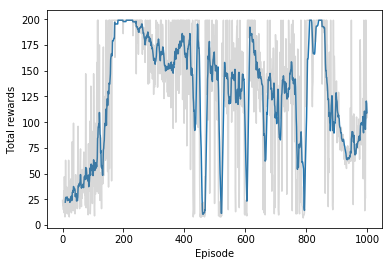

In [30]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Q losses')

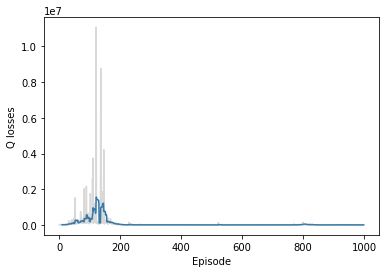

In [31]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

Text(0,0.5,'G losses')

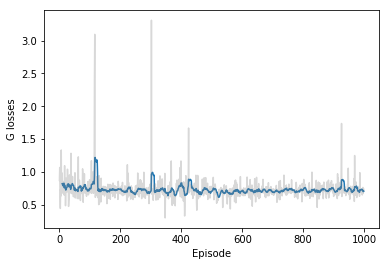

In [32]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

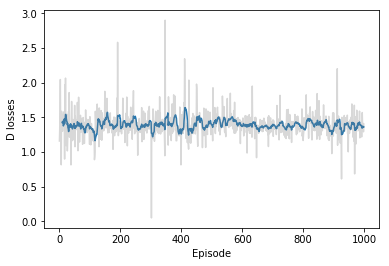

In [33]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [35]:
test_episodes = 5
test_max_steps = 200
env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    saver.restore(sess, 'checkpoints/Q-GAN-cartpole.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

# Closing the env
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/Q-GAN-cartpole.ckpt


ArgumentError: argument 2: <class 'TypeError'>: wrong type

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.